<a href="https://colab.research.google.com/github/areeshaaslam406/-Artistic-Filter-App/blob/main/Artistic_Filter_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload image to apply artistic filter:


Saving toys images2.jpg to toys images2 (1).jpg

Available filters:
1. soft_cartoon
2. strong_cartoon
3. pencil_sketch
4. watercolor
5. oil_painting
6. pop_art
7. hd_enhanced
8. vintage
9. grayscale_art

Type filter name to use, 'list' to see details, 'save' to save current as preset, or 'custom' to enter params: pop_art
Using preset: pop_art
Saved: artistic_pop_art.jpg


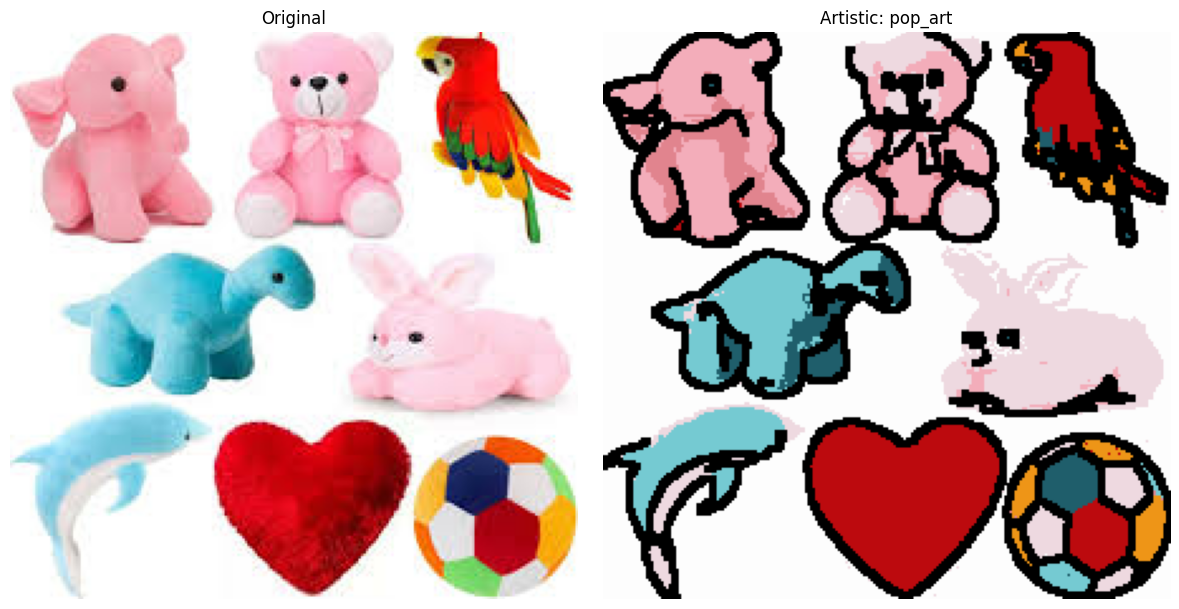

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# =========================================================
# 🎭 Project 2 — Advanced Artistic Filters App (Colab-ready)
# - Upload an image
# - Choose from multiple artistic filters:
#   * Cartoon (multiple styles)
#   * Pencil Sketch
#   * Watercolor
#   * Oil Painting
#   * Pop Art
#   * Enhanced HD
#   * Vintage
#   * Grayscale Art
# - Adjust parameters for each filter
# - Save presets, save final image
# =========================================================

from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random

# -------------------------
# Helper: Apply various artistic filters
# -------------------------
def apply_filter(img_bgr, filter_name, **params):
    if filter_name == 'cartoon':
        return cartoonize(img_bgr, **params)
    elif filter_name == 'pencil_sketch':
        return pencil_sketch(img_bgr, **params)
    elif filter_name == 'watercolor':
        return watercolor_effect(img_bgr, **params)
    elif filter_name == 'oil_painting':
        return oil_painting(img_bgr, **params)
    elif filter_name == 'pop_art':
        return pop_art(img_bgr, **params)
    elif filter_name == 'enhanced_hd':
        return enhanced_hd(img_bgr, **params)
    elif filter_name == 'vintage':
        return vintage_effect(img_bgr, **params)
    elif filter_name == 'grayscale_art':
        return grayscale_art(img_bgr, **params)
    else:
        raise ValueError(f"Unknown filter: {filter_name}")

def cartoonize(
    img_bgr,
    bilateral_iters=5,     # how many times to apply bilateral filter
    bilateral_d=9,         # diameter of each pixel neighborhood
    bilateral_sigmaColor=75,
    bilateral_sigmaSpace=75,
    median_ksize=7,        # median blur kernel for edge detection (odd)
    use_canny=False,       # if True use Canny for edges, else adaptive threshold
    canny_thr1=100,
    canny_thr2=200,
    edge_dilate=1,         # dilate edges to make them bolder
    posterize_levels=None  # if int -> reduce color levels (e.g., 8)
):
    # 1) smooth colors by repeating bilateral filtering
    smooth = img_bgr.copy()
    for _ in range(max(1, bilateral_iters)):
        smooth = cv2.bilateralFilter(smooth, bilateral_d, bilateral_sigmaColor, bilateral_sigmaSpace)

    # Optional: posterize (reduce number of color values) to get flat regions
    if posterize_levels and posterize_levels > 1:
        factor = 256 // posterize_levels
        smooth = (smooth // factor) * factor
        smooth = smooth.astype(np.uint8)

    # 2) prepare edges
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.medianBlur(gray, median_ksize)

    if use_canny:
        edges = cv2.Canny(gray_blur, canny_thr1, canny_thr2)
        if edge_dilate > 0:
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (edge_dilate*2+1, edge_dilate*2+1))
            edges = cv2.dilate(edges, kernel, iterations=1)
    else:
        edges = cv2.adaptiveThreshold(
            gray_blur, 255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            9, 2
        )
        edges = cv2.bitwise_not(edges)
        if edge_dilate > 0:
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (edge_dilate*2+1, edge_dilate*2+1))
            edges = cv2.dilate(edges, kernel, iterations=1)

    if edges.ndim == 2:
        mask = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    else:
        mask = edges

    cartoon_bgr = cv2.bitwise_and(smooth, mask)
    return cartoon_bgr

def pencil_sketch(img_bgr, invert=True, blur_ksize=21, edge_ksize=3):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    sketch = cv2.divide(gray, blur, scale=256)

    if invert:
        sketch = cv2.bitwise_not(sketch)

    return cv2.cvtColor(sketch, cv2.COLOR_GRAY2BGR)

def watercolor_effect(img_bgr, bilateral_iter=3, bilateral_d=9, sigmaColor=50, sigmaSpace=50, median_ksize=5):
    watercolor = img_bgr.copy()
    for _ in range(bilateral_iter):
        watercolor = cv2.bilateralFilter(watercolor, bilateral_d, sigmaColor, sigmaSpace)
    watercolor = cv2.stylization(watercolor, sigma_s=60, sigma_r=0.6)
    return watercolor

def oil_painting(img_bgr, size=7, dynRatio=1):
    return cv2.xphoto.oilPainting(img_bgr, size=size, dynRatio=dynRatio)

def pop_art(img_bgr, num_colors=8, edge_thickness=2):
    # Posterize
    Z = img_bgr.reshape((-1,3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    pop = res.reshape((img_bgr.shape))

    # Add black edges
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges = cv2.dilate(edges, None)
    pop[edges > 0] = [0, 0, 0]
    return pop

def enhanced_hd(img_bgr, clarity=1.5, brightness=0, contrast=1.1):
    # Convert to LAB color space
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)

    # Merge channels and convert back to BGR
    enhanced_lab = cv2.merge((l, a, b))
    enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # Adjust brightness and contrast
    enhanced = cv2.convertScaleAbs(enhanced, alpha=contrast, beta=brightness)

    # Sharpening
    kernel = np.array([[-1,-1,-1], [-1,9*clarity,-1], [-1,-1,-1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)

    return enhanced

def vintage_effect(img_bgr, sepia_strength=0.8, vignette_strength=0.7, noise_strength=0.05):
    # Sepia effect
    sepia_filter = np.array([
        [0.393, 0.769, 0.189],
        [0.349, 0.686, 0.168],
        [0.272, 0.534, 0.131]
    ])
    vintage = cv2.transform(img_bgr, sepia_filter)
    vintage = cv2.addWeighted(vintage, sepia_strength, img_bgr, 1-sepia_strength, 0)

    # Vignette effect
    rows, cols = vintage.shape[:2]
    X_resultant_kernel = cv2.getGaussianKernel(cols, cols/3)
    Y_resultant_kernel = cv2.getGaussianKernel(rows, rows/3)
    kernel = Y_resultant_kernel * X_resultant_kernel.T
    mask = kernel / kernel.max()
    vintage = np.uint8(vintage * (mask[..., np.newaxis] * (1-vignette_strength) + vignette_strength))

    # Add noise
    noise = np.random.randint(0, 50, (rows, cols, 3), dtype=np.uint8)
    vintage = cv2.addWeighted(vintage, 1-noise_strength, noise, noise_strength, 0)

    return vintage

def grayscale_art(img_bgr, blur_ksize=5, edge_ksize=3, stylize=True):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    if stylize:
        gray = cv2.stylization(gray, sigma_s=60, sigma_r=0.07)
    return cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

# -------------------------
# Default presets
# -------------------------
default_presets = {
    "soft_cartoon": {
        "filter": "cartoon",
        "params": {
            "bilateral_iters": 4, "bilateral_d": 9, "bilateral_sigmaColor": 75, "bilateral_sigmaSpace": 75,
            "median_ksize": 7, "use_canny": False, "edge_dilate": 1, "posterize_levels": 12
        }
    },
    "strong_cartoon": {
        "filter": "cartoon",
        "params": {
            "bilateral_iters": 7, "bilateral_d": 9, "bilateral_sigmaColor": 100, "bilateral_sigmaSpace": 100,
            "median_ksize": 7, "use_canny": False, "edge_dilate": 2, "posterize_levels": 8
        }
    },
    "pencil_sketch": {
        "filter": "pencil_sketch",
        "params": {"invert": True, "blur_ksize": 21, "edge_ksize": 3}
    },
    "watercolor": {
        "filter": "watercolor",
        "params": {"bilateral_iter": 3, "bilateral_d": 9, "sigmaColor": 50, "sigmaSpace": 50, "median_ksize": 5}
    },
    "oil_painting": {
        "filter": "oil_painting",
        "params": {"size": 7, "dynRatio": 1}
    },
    "pop_art": {
        "filter": "pop_art",
        "params": {"num_colors": 8, "edge_thickness": 2}
    },
    "hd_enhanced": {
        "filter": "enhanced_hd",
        "params": {"clarity": 1.5, "brightness": 0, "contrast": 1.1}
    },
    "vintage": {
        "filter": "vintage",
        "params": {"sepia_strength": 0.8, "vignette_strength": 0.7, "noise_strength": 0.05}
    },
    "grayscale_art": {
        "filter": "grayscale_art",
        "params": {"blur_ksize": 5, "edge_ksize": 3, "stylize": True}
    }
}

# Save presets file helper
PRESET_FILENAME = "artistic_presets.json"
if os.path.exists(PRESET_FILENAME):
    try:
        with open(PRESET_FILENAME, "r") as f:
            saved_presets = json.load(f)
            default_presets.update(saved_presets)
    except Exception:
        pass  # ignore corrupt file

# -------------------------
# 0) Upload image
# -------------------------
print("Upload image to apply artistic filter:")
up = files.upload()
img_path = list(up.keys())[0]

img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError("Could not read the image. Re-upload a valid JPG/PNG.")

# -------------------------
# 1) Ask user to choose filter
# -------------------------
print("\nAvailable filters:")
for i, preset in enumerate(default_presets.keys()):
    print(f"{i+1}. {preset}")

choice = input("\nType filter name to use, 'list' to see details, 'save' to save current as preset, or 'custom' to enter params: ").strip()

params = None
filter_name = None

if choice == "list":
    print(json.dumps(default_presets, indent=2))
    choice = input("Now type filter name to use or 'custom': ").strip()

if choice in default_presets:
    filter_name = default_presets[choice]["filter"]
    params = default_presets[choice]["params"]
    print(f"Using preset: {choice}")
elif choice == "custom":
    print("\nAvailable filter types: cartoon, pencil_sketch, watercolor, oil_painting, pop_art, enhanced_hd, vintage, grayscale_art")
    filter_name = input("Enter filter type: ").strip()

    if filter_name not in ['cartoon', 'pencil_sketch', 'watercolor', 'oil_painting', 'pop_art', 'enhanced_hd', 'vintage', 'grayscale_art']:
        print("Unknown filter, using 'soft_cartoon'")
        filter_name = default_presets["soft_cartoon"]["filter"]
        params = default_presets["soft_cartoon"]["params"]
    else:
        params = {}
        # Get basic parameters for the selected filter
        if filter_name == 'cartoon':
            params['bilateral_iters'] = int(input("bilateral_iters (e.g., 4): ") or "4")
            params['bilateral_d'] = int(input("bilateral_d (odd, e.g., 9): ") or "9")
            params['bilateral_sigmaColor'] = float(input("bilateral_sigmaColor (e.g., 75): ") or "75")
            params['bilateral_sigmaSpace'] = float(input("bilateral_sigmaSpace (e.g., 75): ") or "75")
            params['median_ksize'] = int(input("median_ksize (odd, e.g., 7): ") or "7")
            params['use_canny'] = input("use_canny? (y/N): ").strip().lower() == "y"
            if params['use_canny']:
                params['canny_thr1'] = int(input("canny_thr1 (e.g., 100): ") or "100")
                params['canny_thr2'] = int(input("canny_thr2 (e.g., 200): ") or "200")
            params['edge_dilate'] = int(input("edge_dilate (e.g., 1): ") or "1")
            posterize_levels_in = input("posterize_levels (int or blank for none, e.g., 8): ").strip()
            params['posterize_levels'] = int(posterize_levels_in) if posterize_levels_in else None
        elif filter_name == 'pencil_sketch':
            params['invert'] = input("invert sketch? (Y/n): ").strip().lower() != "n"
            params['blur_ksize'] = int(input("blur kernel size (odd, e.g., 21): ") or "21")
            params['edge_ksize'] = int(input("edge kernel size (odd, e.g., 3): ") or "3")
        elif filter_name == 'watercolor':
            params['bilateral_iter'] = int(input("bilateral iterations (e.g., 3): ") or "3")
            params['bilateral_d'] = int(input("bilateral_d (odd, e.g., 9): ") or "9")
            params['sigmaColor'] = float(input("sigmaColor (e.g., 50): ") or "50")
            params['sigmaSpace'] = float(input("sigmaSpace (e.g., 50): ") or "50")
            params['median_ksize'] = int(input("median_ksize (odd, e.g., 5): ") or "5")
        elif filter_name == 'oil_painting':
            params['size'] = int(input("brush size (e.g., 7): ") or "7")
            params['dynRatio'] = float(input("dynRatio (e.g., 1.0): ") or "1.0")
        elif filter_name == 'pop_art':
            params['num_colors'] = int(input("number of colors (e.g., 8): ") or "8")
            params['edge_thickness'] = int(input("edge thickness (e.g., 2): ") or "2")
        elif filter_name == 'enhanced_hd':
            params['clarity'] = float(input("clarity (e.g., 1.5): ") or "1.5")
            params['brightness'] = int(input("brightness (-100 to 100, e.g., 0): ") or "0")
            params['contrast'] = float(input("contrast (e.g., 1.1): ") or "1.1")
        elif filter_name == 'vintage':
            params['sepia_strength'] = float(input("sepia strength (0-1, e.g., 0.8): ") or "0.8")
            params['vignette_strength'] = float(input("vignette strength (0-1, e.g., 0.7): ") or "0.7")
            params['noise_strength'] = float(input("noise strength (0-0.2, e.g., 0.05): ") or "0.05")
        elif filter_name == 'grayscale_art':
            params['blur_ksize'] = int(input("blur kernel size (odd, e.g., 5): ") or "5")
            params['edge_ksize'] = int(input("edge kernel size (odd, e.g., 3): ") or "3")
            params['stylize'] = input("apply stylization? (Y/n): ").strip().lower() != "n"

        # Option to save this custom as preset
        save_choice = input("\nSave these params as a new preset? (y/N): ").strip().lower()
        if save_choice == "y":
            name = input("Preset name: ").strip()
            if name:
                default_presets[name] = {
                    "filter": filter_name,
                    "params": params
                }
                with open(PRESET_FILENAME, "w") as f:
                    json.dump({k:v for k,v in default_presets.items()}, f, indent=2)
                print(f"Saved preset '{name}' to {PRESET_FILENAME}")
else:
    print("Unknown choice — falling back to 'soft_cartoon'.")
    filter_name = default_presets["soft_cartoon"]["filter"]
    params = default_presets["soft_cartoon"]["params"]

# -------------------------
# 2) Apply selected filter
# -------------------------
result = apply_filter(img_bgr, filter_name, **params)

# -------------------------
# 3) Save & preview
# -------------------------
out_name = f"artistic_{filter_name}.jpg"
cv2.imwrite(out_name, result)
print(f"Saved: {out_name}")

# Display side-by-side (convert BGR->RGB for matplotlib)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(result_rgb); plt.title(f"Artistic: {filter_name}"); plt.axis("off")
plt.tight_layout(); plt.show()

# Offer download
files.download(out_name)